# Tone Classification

This notebook conducts three tasks:

1. Acquires tweets from a Kaggle dataset that are English
1. Uses a local LLM to generate different tone transformations of those tweets
1. Creates classifiers for those different tones

By the end of the notebook, four classifiers are built.  These classifiers assess different characteristics of tone:
1. Formality
1. Optimism
1. Apologetic-ness
1. Compassion

## Constants

In [1]:
RANDOM_SEED = 42
LLM_MODEL = "llama3.1:8b"
MIN_TWEET_TOKENS = 15  # min tokens for a tweet to be used
LLM_SAMPLE_SIZE = 6000  # how many tweets to transform and use in training

# execution options
GENERATE_RAW_TRAINING_DATA = True
GENERATE_LLM_TRAINING_DATA = True
TRAIN_MODEL = True

## Imports and Helper Functions

In [40]:
import csv
import langdetect
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import scipy
import seaborn as sns
import sqlite3
import time
import torch
import torchview

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from datasets import Dataset
from IPython.display import display, HTML, clear_output
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from lyricsgenius import Genius
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
from transformers import BertModel, BertTokenizer


class MSEPlot:
    """Ugly code! Dynamically updates plots of MSE so that one can visualize 
    error in real-time as a model trains.
    """
    def __init__(self):
        plt.ion()
        self.fig, self.ax = plt.subplots(1, 1)
        self.is_flushed = False

    def update(self, train_mse, validation_mse, title="", include_mse=True, epoch=None, batch=None, max_batches=None):
        if len(title) > 0:
            title = f"{title}\n"

        if epoch is not None and batch is not None:
            if max_batches is not None:
                title = f"{title}\nEpoch: {epoch}, {batch/max_batches*100:.0f}%"
            else:
                title = f"{title}\nEpoch: {epoch}, Batch: {batch}"
        elif epoch is not None:
            title = f"{title}\nEpoch: {epoch}"

        if include_mse and len(train_mse) > 0:
            title = f"{title}\nTrain: {train_mse[-1]:.3f}, Validation: {validation_mse[-1]:.3f}"
        
        self.ax.clear()
        self.ax.plot(train_mse)
        self.ax.plot(validation_mse)
        self.ax.legend(["Training", "Validation"], loc="upper right")
        if len(title) > 0:
            self.ax.set_title(title, fontsize=10)
        display(self.fig)
        clear_output(wait=True)
        self.is_flushed = False

    def flush(self):
        if not self.is_flushed:
            plt.ioff()
            display(self.fig)
            clear_output(wait=False)
            display(self.fig)
            self.is_flushed = True
    
    def __del__(self):
        if not self.is_flushed:
            self.flush()


def data_split(X, y, percentages):
    """Split data into train/test, train/validation/test, or any other variant.
    @percentages is a tuple or list of percentages, each one the percentage of data
    that should be in the returned partition.

    Example:
    X_train, y_train, X_validation, y_validation, X_test, y_test = data_split(X, y, (0.8, 0.1, 0.1))
    """
    if isinstance(percentages, (tuple, list)):
        percentages = np.array(percentages)
    if np.abs(percentages.sum() - 1) > 1e-4:
        raise ValueError("percentages must sum to 1")
    mask = np.random.rand(len(X)) <= percentages[0]
    data = [X[mask], y[mask]]
    if len(percentages) > 1:
        data += data_split(X[~mask], y[~mask], percentages[1:] / (1 - percentages[0]))
    return data

## Configuration and Widely Used Variables

In [3]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

## Get/Transform Data from Kaggle

In [4]:
if GENERATE_RAW_TRAINING_DATA:
    records = []
    
    # dataset: https://www.kaggle.com/datasets/kazanova/sentiment140
    with open("/home/mallinger/Code/data/tone-classifier/training.1600000.processed.noemoticon.csv", mode="r") as fh:
        csv_reader = csv.reader(fh)
        while True:
            try:
                row = next(csv_reader)
                text = row[5]
                if langdetect.detect(text) == "en":
                    records += [("sentiment140", text)]
            except (langdetect.LangDetectException, UnicodeDecodeError, IndexError) as e:
                pass
            except StopIteration:
                break
    
    raw_text_df = pd.DataFrame(records, columns=["source", "text"])
    raw_text_df.to_pickle("/home/mallinger/Code/data/tone-classifier/raw_text_df")

## Use LLM to Generate Example Tone Text from Tweets

In [5]:
TONES = {"formal": ("informal and friendly, characterized by bubbly and outgoing language", "formal and distanced, characterized by flat and unemotional language"),
         "optimistic": ("pessimistic, characterized by a negative outlook", "optimistic, characterized by positive, forward-looking language"),
         "apologetic": ("defensive, characterized by denial and pushback", "apologetic, characterized by regret and a focus on restitution"),
         "compassionate": ("insensitive, characterized by a disregard for the feelings of others", "warm, gentle, and empathetic, characterized by a deep concern for another's well-being or struggles"),
        }
template = ChatPromptTemplate.from_messages([("system", 
                                              """You are a helpful chatbot that is trained to rewrite text in different tones.
                                              For example, you can rewrite a text message to be more happy and cheerful.

                                              Rewrite the text submitted by the user to be very {description}.  
                                              Do not print any other text or characters.
                                              """),
                                             ("human", 
                                              "{text}"
                                             )])

def get_tone_examples(text):
    records = []
    for tone, (negative_description, positive_description) in TONES.items():
        negative_example_text = llm.invoke(template.format_messages(description=negative_description, text=text), keep_alive=0)
        positive_example_text = llm.invoke(template.format_messages(description=positive_description, text=text), keep_alive=0)
        records += [(tone, text, positive_example_text, negative_example_text)]
    return records


if GENERATE_LLM_TRAINING_DATA:
    llm = OllamaLLM(model=LLM_MODEL, temperature=0.7)
    records = []
    raw_text_df = pd.read_pickle("/home/mallinger/Code/data/tone-classifier/raw_text_df")
    corporus = random.sample([text for text in raw_text_df["text"] if len(re.split(r"\s+", text)) >= MIN_TWEET_TOKENS], LLM_SAMPLE_SIZE)
    with ProcessPoolExecutor(max_workers=32) as executor:
        futures = [executor.submit(get_tone_examples, text) for text in corporus]
        for future in tqdm(as_completed(futures), total=len(corporus)):
            records += [future.result()]
        records = sum(records, [])  # flatten
    text_df = pd.DataFrame(records, columns=["topic", "original", "positive", "negative"])
    text_df.to_pickle("/home/mallinger/Code/data/tone-classifier/text_df")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [53:36:44<00:00, 32.17s/it]


## Modeling Helper Functions

In [24]:
class Model(nn.Module):
    def __init__(self, bert_model, hidden_layer_size):
        super(Model, self).__init__()
        self.bert_model = BertModel.from_pretrained(bert_model)
        bert_final_layer_size = len(list(self.bert_model.parameters())[-1])
        # freeze the bert model, i.e. only train our layers
        for param in self.bert_model.parameters():
            param.requires_grad = False

        self.hidden_layer = nn.Linear(bert_final_layer_size, hidden_layer_size)
        self.batch_norm = nn.BatchNorm1d(hidden_layer_size)
        self.classification_layer = nn.Linear(hidden_layer_size, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        input_ids = X[:, :, 0]
        attention_mask = X[:, :, 1]
        bert_output = self.bert_model(input_ids, attention_mask).pooler_output
        hidden_layer_output = self.relu(self.batch_norm(self.hidden_layer(bert_output)))
        classification_output = self.classification_layer(hidden_layer_output)
        return classification_output


def get_model_df(text_df, tone, columns, bert_model="bert-base-cased"):
    """Given a text dataframe, reformat it for training purposes"""
    df = text_df[text_df["topic"] == tone]
    tokenizer = BertTokenizer.from_pretrained(bert_model)

    input_dfs = []
    for column, score in columns.items():
        bert_input = [tokenizer(text, padding="max_length", max_length=512, truncation=True, return_tensors="pt") for text in df[column]]
        input_dfs.append(pd.DataFrame({"score": score, "text": df[column], "bert_input": bert_input}))
        
    return pd.concat(input_dfs).reset_index()


def convert_model_df_to_tensor(df, device="cpu"):
    """Given a dataframe returned from `get_model_df`, return the data as tensors"""
    X = np.column_stack(([o["input_ids"] for o in df["bert_input"]], 
                         [o["attention_mask"] for o in df["bert_input"]]))
    X = np.transpose(X, axes=(0, 2, 1))
    y = df["score"].to_numpy().squeeze()
    return torch.tensor(X, device=device), torch.tensor(y, device=device)


def get_model(hidden_layer_width, bert_model="bert-base-cased", device="cpu"):
    """Return a tone model"""
    return Model(bert_model, hidden_layer_width).to(device=device)


def train_model(model, X_train, y_train, X_validation, y_validation, n_epochs=100, batch_size=4, lr=1e-5, weight_decay=0):
    """Train the tone model for a specific tone based on the dataset passed."""
    model_device = next(model.parameters()).device
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # store (and plot) the MSE by epoch for train and test
    mse_history_train, mse_history_validation = [], []
    # plot the change in MSE over time
    mse_plot = MSEPlot()

    for epoch in range(n_epochs):
        model.train()
        indices = np.random.permutation(len(X_train))
        batches = len(X_train) // batch_size
        for batch in range(batches):
            # random batch.  todo: use a dataloader here
            slice_ = indices[batch*batch_size:batch*batch_size+batch_size]
            X_batch = X_train[slice_].to(model_device)
            y_batch = y_train[slice_].to(model_device)
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # calculate MSE per epoch
        mse_history_train.append(get_model_loss(model, loss_fn, X_train, y_train))
        mse_history_validation.append(get_model_loss(model, loss_fn, X_validation, y_validation))
        # update graph
        mse_plot.update(mse_history_train, mse_history_validation, epoch=epoch, batch=batch, max_batches=batches)

    # ensure graph renders above additional information
    mse_plot.flush()
    return model


def bulk_predict(model, X, batch_size=50):
    model_device = next(model.parameters()).device
    y_pred_list = []
    model.eval()
    with torch.inference_mode():
        for i in range(0, len(X), batch_size):
            y_pred_list.append(model(X[i:i+batch_size].to(model_device)).squeeze().cpu())
        y_pred = torch.tensor([y for list_ in y_pred_list for y in list_])
    return y_pred


def get_model_loss(model, loss_fn, X, y, batch_size=50):
    """Return the MSE of this model for this loss function and data"""
    y_pred = bulk_predict(model, X, batch_size)
    loss = float(loss_fn(y_pred, y.cpu()))
    return loss


def get_model_classification_report(model, X, y, batch_size=50):
    """Return the classification report of this model for this data"""
    y_pred = torch.sigmoid(bulk_predict(model, X, batch_size))
    return classification_report(y.cpu().numpy(), (y_pred >= 0.5).numpy().astype(int))

## Train the Formal Speech Text Classifier

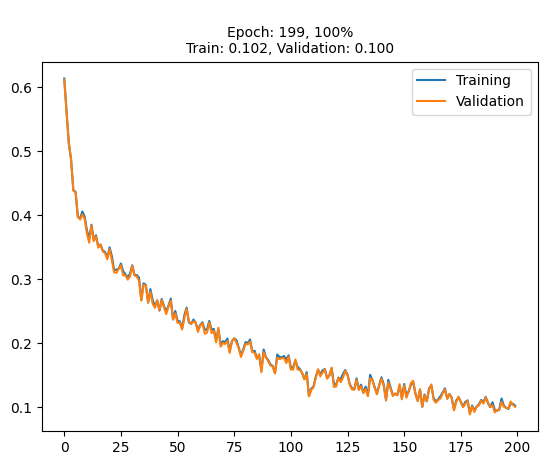

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       907
         1.0       1.00      1.00      1.00       900

    accuracy                           1.00      1807
   macro avg       1.00      1.00      1.00      1807
weighted avg       1.00      1.00      1.00      1807



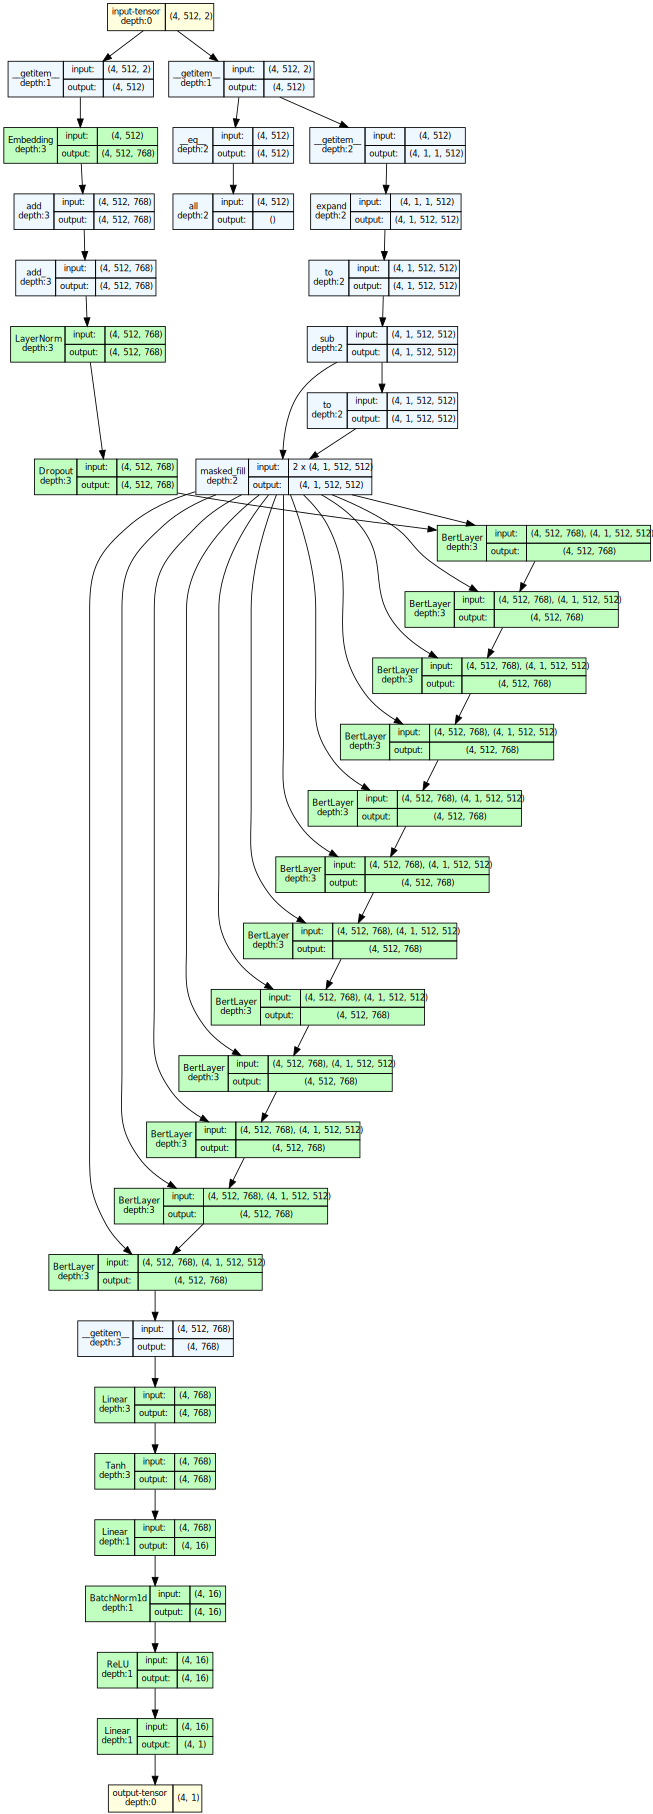

,text,prediction,prediction_percentile
2318,@midphase our website is down. seems the hosting company has some datacenter issues. that is the first time in over three years.,0.644377,96.550000
5202,"@give_me_a_latte and btw, won't take you 13 months. Being pregnant for the last 8 have made things a bit more... complicated.",0.537970,91.850000
4367,I may develop a fear of flying after today Prayers to all the people suffering through the AF tragedy.,0.750283,98.933333
5226,Trying out a new Twitter app for my Blackberry. Sorry to spam your feed.,0.618591,95.483333
4062,is watching the extras disk of &quot;Star Wreck&quot; - all the items but none of the menus,0.757439,99.083333
2459,"Perrtay good day. Tomorrow will be good too. Rb early in the morn, then b&amp;n",0.283357,63.533333
835,@travisweber @travisweber I heard an assistant principle died of the swine in NY... Might be that,0.313975,70.000000
5208,@therainisfallen i would have to agree about the rain. shame most of the rest of the things inmy life are bleh,0.284504,63.933333
1276,Why is it so crappy out? This weekend is going to be a boring weekend.,0.284799,63.983333
5213,The worst part of living alone: no one to rub in the lotion on your back.,0.303389,67.750000


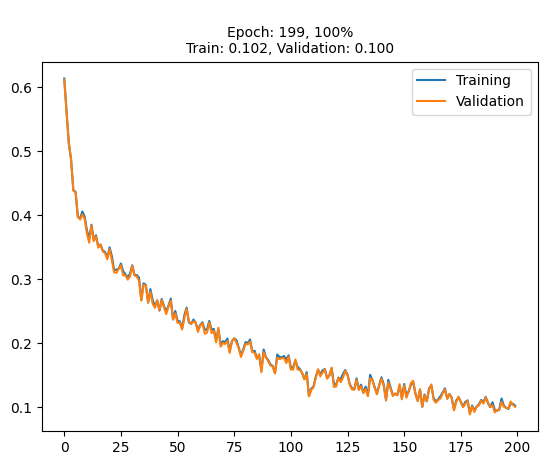

In [33]:
if TRAIN_MODEL:
    # text data loading and transformation
    text_df = pd.read_pickle("/home/mallinger/Code/data/tone-classifier/text_df")
    df = get_model_df(text_df, "formal", columns={"positive": 1.0, "negative": 0.0})
    X, y = convert_model_df_to_tensor(df)
    X_train, y_train, X_validation, y_validation, X_test, y_test = data_split(X, y, (0.7, 0.15, 0.15))

    # model creation
    model = get_model(16, device=DEVICE)
    model = train_model(model, X_train, y_train, X_validation, y_validation, n_epochs=200, batch_size=4, lr=1e-6, weight_decay=1e-2)
    torch.save(model, "/home/mallinger/Code/ml-examples/models/formal_speech.pt")
    
    # classification report
    print(get_model_classification_report(model, X_test, y_test))
    
    # render model architecture
    model_graph = torchview.draw_graph(model, input_data=X_test[0:4])
    display(model_graph.visual_graph)

    # example df from original sources
    original_df = get_model_df(text_df, "formal", columns={"original": -1.0})
    original_X, original_y = convert_model_df_to_tensor(original_df)
    y_pred = torch.sigmoid(bulk_predict(model, original_X, batch_size=50))
    original_df["prediction"] = y_pred.numpy()
    original_df["prediction_percentile"] = scipy.stats.percentileofscore(original_df["prediction"], original_df["prediction"])
    examples_df = pd.concat([original_df[original_df["prediction_percentile"] >= 90].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 60) & (original_df["prediction_percentile"] <= 70)].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 30) & (original_df["prediction_percentile"] <= 40)].sample(5),
                             original_df[original_df["prediction_percentile"] <= 10].sample(5),
                            ])
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        display(examples_df[["text", "prediction", "prediction_percentile"]])

## Train the Optimistic Speech Text Classifier

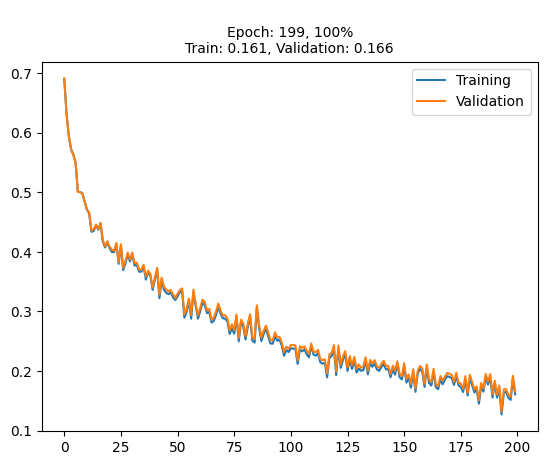

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       887
         1.0       0.99      0.98      0.98       885

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772



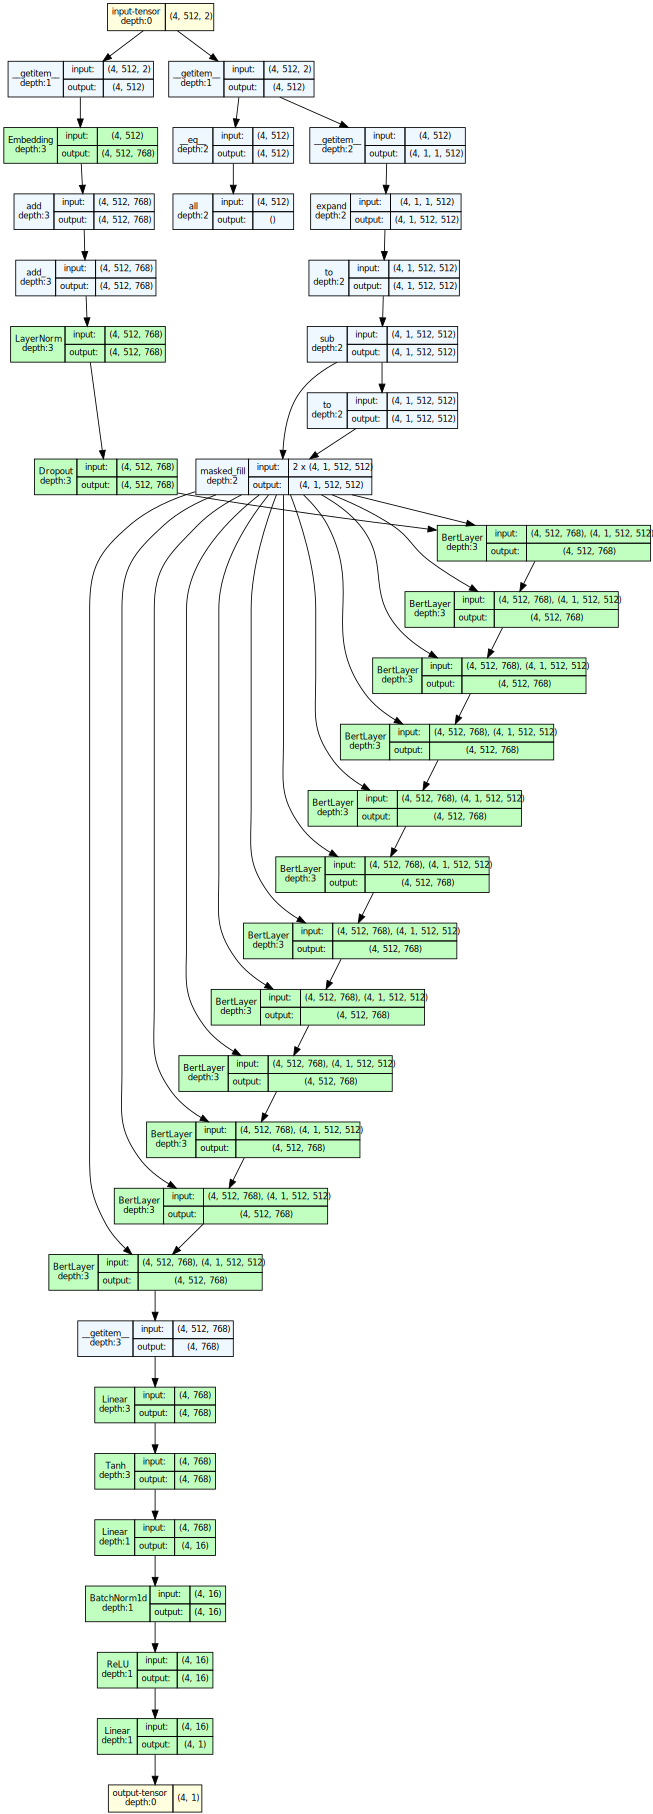

,text,prediction,prediction_percentile
5347,"@tommcfly why you at the studio then? just watched a video of you guys and the jonas brothers last night, it looked amazing!",0.875256,99.366667
2749,@illmaticP ilymore babe!! I thought bout you and how you walked from riverwood to my job just for me two yrs ago ahhh come home asap!,0.639314,92.716667
1983,@bethyesterday I know the final project is amazing because you're amazing at what you do! Thank you so much!,0.875381,99.383333
1838,is having a wonderful birthday so far thanks to my friends and it's only 7!,0.631657,92.250000
2422,"@brooklynn07 haha i love you bug. Im stuck babysitting, but im going to sleep .. Night besty!!",0.680583,94.350000
3789,@graywolf Google should consider selling their Michael Gray dartboards. I think they would be a big hit.,0.326012,69.266667
3669,@happylovesChuck I kinda did exactly that today - haha! But tomorrow I'll have to get cracking,0.306204,66.233333
961,@Hughesie Umm... I'e gone over my bandwidth usage for my site... Any chance I can have some more? Please? Sorry!,0.319251,68.166667
4622,Today: 1. Dentist 2. Downtown with my girlies 3. Famous videoshoot 4. Go back home &amp; work.,0.325563,69.166667
2942,@marcusafinley I like the iPhone on the AT&amp;T network. I don't see tmobile releasing the sidekick. It's our exclusive,0.291411,63.633333


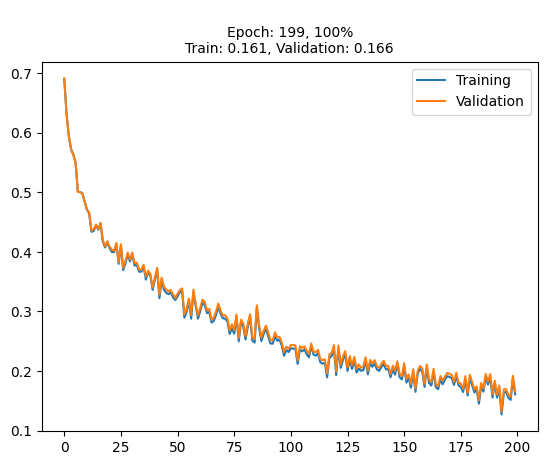

In [34]:
if TRAIN_MODEL:
    # text data loading and transformation
    text_df = pd.read_pickle("/home/mallinger/Code/data/tone-classifier/text_df")
    df = get_model_df(text_df, "optimistic", columns={"positive": 1.0, "negative": 0.0})
    X, y = convert_model_df_to_tensor(df)
    X_train, y_train, X_validation, y_validation, X_test, y_test = data_split(X, y, (0.7, 0.15, 0.15))

    # model creation
    model = get_model(16, device=DEVICE)
    model = train_model(model, X_train, y_train, X_validation, y_validation, n_epochs=200, batch_size=4, lr=1e-6, weight_decay=1e-2)
    torch.save(model, "/home/mallinger/Code/ml-examples/models/optimistic_speech.pt")
    
    # classification report
    print(get_model_classification_report(model, X_test, y_test))
    
    # render model architecture
    model_graph = torchview.draw_graph(model, input_data=X_test[0:4])
    display(model_graph.visual_graph)

    # example df from original sources
    original_df = get_model_df(text_df, "formal", columns={"original": -1.0})
    original_X, original_y = convert_model_df_to_tensor(original_df)
    y_pred = torch.sigmoid(bulk_predict(model, original_X, batch_size=50))
    original_df["prediction"] = y_pred.numpy()
    original_df["prediction_percentile"] = scipy.stats.percentileofscore(original_df["prediction"], original_df["prediction"])
    examples_df = pd.concat([original_df[original_df["prediction_percentile"] >= 90].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 60) & (original_df["prediction_percentile"] <= 70)].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 30) & (original_df["prediction_percentile"] <= 40)].sample(5),
                             original_df[original_df["prediction_percentile"] <= 10].sample(5),
                            ])
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        display(examples_df[["text", "prediction", "prediction_percentile"]])

## Train the Apologetic Speech Text Classifier

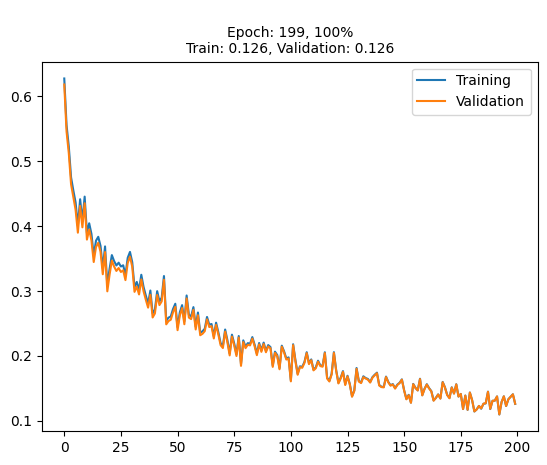

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       895
         1.0       0.99      1.00      0.99       882

    accuracy                           0.99      1777
   macro avg       0.99      0.99      0.99      1777
weighted avg       0.99      0.99      0.99      1777



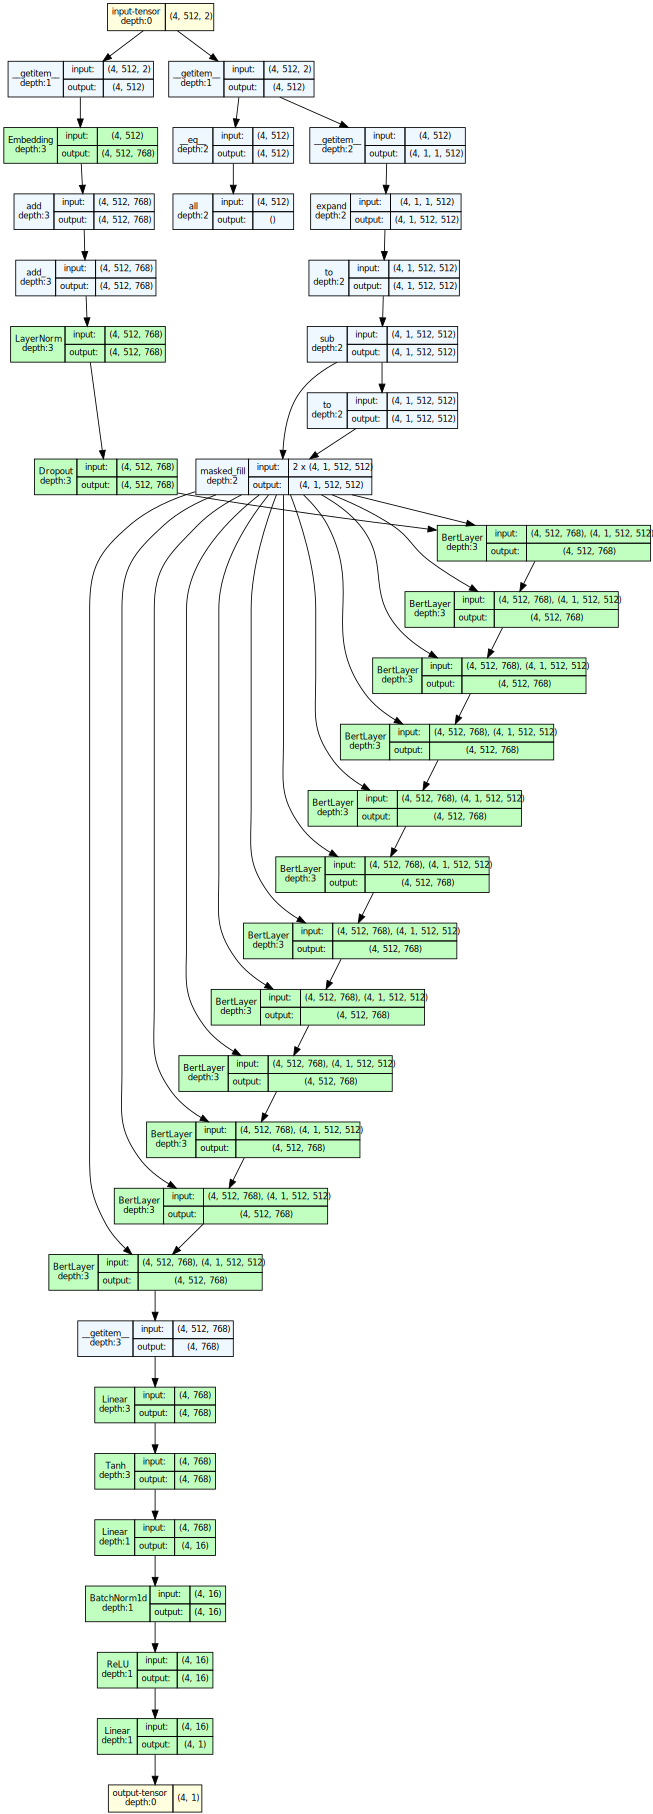

,text,prediction,prediction_percentile
5823,going to see UP! then playing a show with my brother at South Bound @ 7pm! will you be there?,0.589198,94.366667
4137,Good morning everybody. Wishing you a wonderful day full of smile and success. Follow me as I smile to you,0.849311,99.850000
2550,Show some love: http://bit.ly/12pn9T Please check out the items and leave comments. Many thanks!,0.797289,99.500000
1413,I have not slept all night and in HUGE amounts of pain that said I shall try not to whine. Another beautiful day though,0.666004,97.300000
4297,"@auroracelese Aww, no Emerald Dream? I was looking forward to questing with you later.",0.555306,92.750000
363,"@1cutechicwitfm A friend of mine said those words earlier and I am just passing it along , she was not too happy either",0.300005,60.116667
3621,Soooo sad... My little Ashley had to leave today Already took her to the airport.,0.326297,65.916667
862,"@emily6108 nooo I didn't. everytime I looked over at him, he was already looking at me so I was just soaking that in hahahaha",0.313657,63.133333
1571,"@jordanknight Thank U 4 the great show and M&amp;G! Not sure how U do it, but each show ALWAYS tops the last! BIG HUGS 2 U sweetie",0.304059,61.116667
4801,It has been raining all afternoon hope it's not like that tomorrow. i need more exercise!,0.310191,62.466667


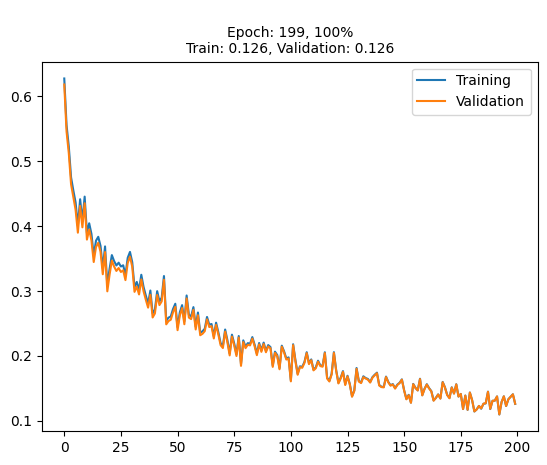

In [35]:
if TRAIN_MODEL:
    # text data loading and transformation
    text_df = pd.read_pickle("/home/mallinger/Code/data/tone-classifier/text_df")
    df = get_model_df(text_df, "apologetic", columns={"positive": 1.0, "negative": 0.0})
    X, y = convert_model_df_to_tensor(df)
    X_train, y_train, X_validation, y_validation, X_test, y_test = data_split(X, y, (0.7, 0.15, 0.15))

    # model creation
    model = get_model(16, device=DEVICE)
    model = train_model(model, X_train, y_train, X_validation, y_validation, n_epochs=200, batch_size=4, lr=1e-6, weight_decay=1e-2)
    torch.save(model, "/home/mallinger/Code/ml-examples/models/apologetic_speech.pt")
    
    # classification report
    print(get_model_classification_report(model, X_test, y_test))
    
    # render model architecture
    model_graph = torchview.draw_graph(model, input_data=X_test[0:4])
    display(model_graph.visual_graph)

    # example df from original sources
    original_df = get_model_df(text_df, "formal", columns={"original": -1.0})
    original_X, original_y = convert_model_df_to_tensor(original_df)
    y_pred = torch.sigmoid(bulk_predict(model, original_X, batch_size=50))
    original_df["prediction"] = y_pred.numpy()
    original_df["prediction_percentile"] = scipy.stats.percentileofscore(original_df["prediction"], original_df["prediction"])
    examples_df = pd.concat([original_df[original_df["prediction_percentile"] >= 90].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 60) & (original_df["prediction_percentile"] <= 70)].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 30) & (original_df["prediction_percentile"] <= 40)].sample(5),
                             original_df[original_df["prediction_percentile"] <= 10].sample(5),
                            ])
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        display(examples_df[["text", "prediction", "prediction_percentile"]])

## Train the Compassionate Speech Text Classifier

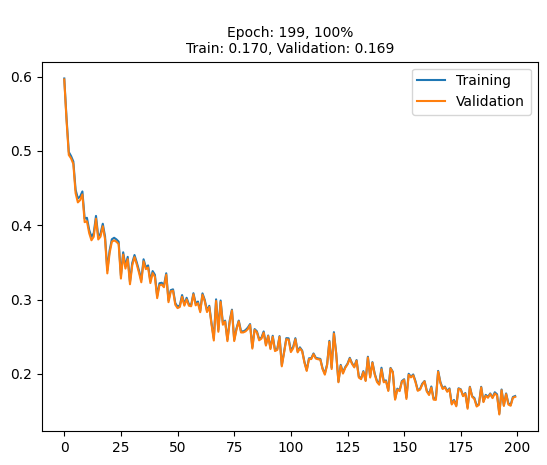

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       878
         1.0       0.99      0.99      0.99       917

    accuracy                           0.99      1795
   macro avg       0.99      0.99      0.99      1795
weighted avg       0.99      0.99      0.99      1795



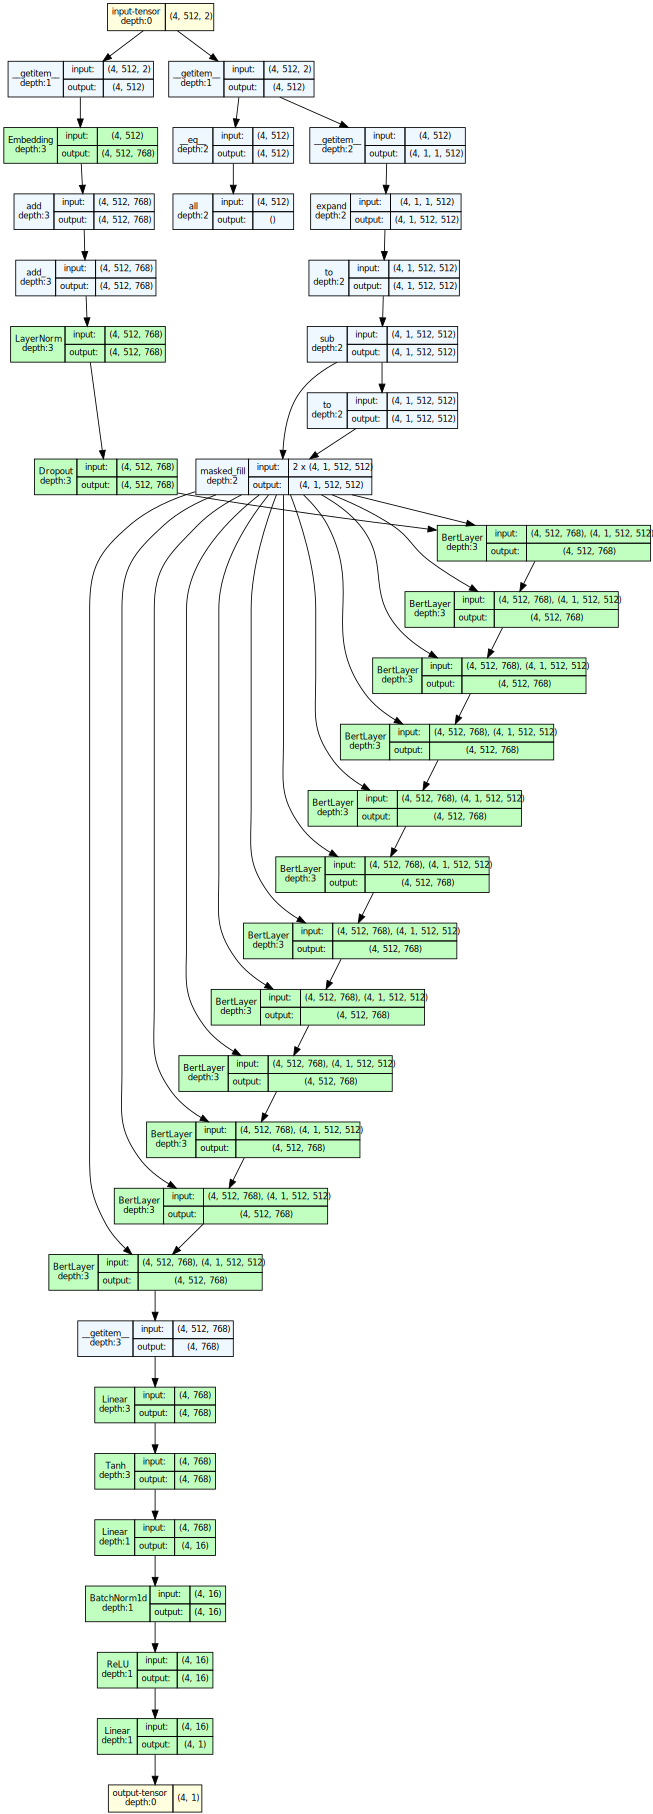

,text,prediction,prediction_percentile
2265,"#asot400 &quot;back to you&quot;...beautiful, yes. but PLEASE can we have some kind of action from Area 1! i really wanted to hear Mr. Sam now SVR!",0.465182,95.483333
5731,@iamsuperbianca Hi Ms. Bianca! I love the Beatles too! Loved them even more when I saw Across the Universe!,0.603083,98.450000
5775,"@casscalogeraxxx I can't wait, you are the best there is I hope someday to do a photo/video shoot with you.",0.602349,98.400000
1475,@Dtballa2322 I want to Forgive and Forget this! Please and I dont like him I promise I am going to live without drama for now!So Please,0.450190,94.983333
2386,Doing some homework after being a kid at Chuck E Cheese with @ambridgeman17 and her awesome son! Thanks Annie for being my friend too,0.588814,98.216667
432,@fi001 not been spoiled yet just home fae Stuarts been there fae 9.30 that's it done wish some1 would come do mine now xxx,0.197174,65.683333
2075,I just found everything that I have lost in the past week apart from the thing I'm looking for - my darn trainer,0.203113,67.200000
1269,"Cash- jus hoped in a cab headin 2 da studio to go attend the meetin, I might be late sorry my nn bruthers! Feeeelin niiiiccccce! :-D",0.194779,64.950000
4751,@katanasquirrel That is an awesome idea. I'll keep that in mind when I get a girlfriend.,0.180597,60.183333
14,I decided to take a sick day today...home without my boy and it's so quiet! Missing my man too,0.192376,64.250000


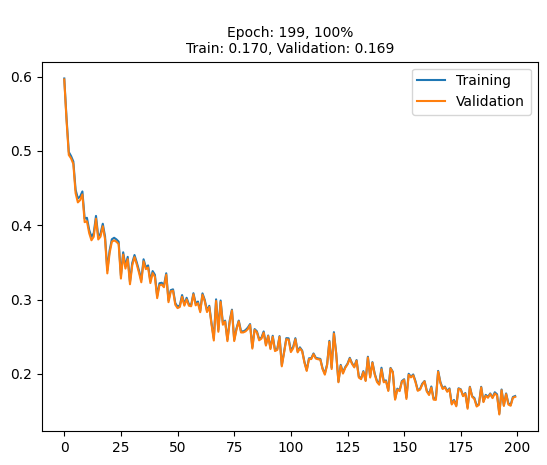

In [36]:
if TRAIN_MODEL:
    # text data loading and transformation
    text_df = pd.read_pickle("/home/mallinger/Code/data/tone-classifier/text_df")
    df = get_model_df(text_df, "compassionate", columns={"positive": 1.0, "negative": 0.0})
    X, y = convert_model_df_to_tensor(df)
    X_train, y_train, X_validation, y_validation, X_test, y_test = data_split(X, y, (0.7, 0.15, 0.15))

    # model creation
    model = get_model(16, device=DEVICE)
    model = train_model(model, X_train, y_train, X_validation, y_validation, n_epochs=200, batch_size=4, lr=1e-6, weight_decay=1e-2)
    torch.save(model, "/home/mallinger/Code/ml-examples/models/compassionate_speech.pt")
    
    # classification report
    print(get_model_classification_report(model, X_test, y_test))
    
    # render model architecture
    model_graph = torchview.draw_graph(model, input_data=X_test[0:4])
    display(model_graph.visual_graph)

    # example df from original sources
    original_df = get_model_df(text_df, "formal", columns={"original": -1.0})
    original_X, original_y = convert_model_df_to_tensor(original_df)
    y_pred = torch.sigmoid(bulk_predict(model, original_X, batch_size=50))
    original_df["prediction"] = y_pred.numpy()
    original_df["prediction_percentile"] = scipy.stats.percentileofscore(original_df["prediction"], original_df["prediction"])
    examples_df = pd.concat([original_df[original_df["prediction_percentile"] >= 90].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 60) & (original_df["prediction_percentile"] <= 70)].sample(5),
                             original_df[(original_df["prediction_percentile"] >= 30) & (original_df["prediction_percentile"] <= 40)].sample(5),
                             original_df[original_df["prediction_percentile"] <= 10].sample(5),
                            ])
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        display(examples_df[["text", "prediction", "prediction_percentile"]])

## Dataset Generation: Taylor Swift Album Lyrics and Tone Classification

In [38]:
TAYLOR_SWIFT_ALBUMS = ["Taylor Swift",
                       "Fearless",
                       "Speak Now",
                       "Red",
                       "1989",
                       "Reputation",
                       "Lover",
                       "Folklore",
                       "Evermore",
                       "Midnights",
                       "The Tortured Poets Department",
                       "The Life of a Showgirl",
                      ]

# use https://genius.com/api-clients to get API tokens
genius_access_token = input("Enter the Genius Client Access Token")
clear_output()

lyrics_data = []
genius = Genius(genius_access_token)
artist = genius.search_artist("Taylor Swift", max_songs=1,  sort="popularity")
for album_name in TAYLOR_SWIFT_ALBUMS:
    album = genius.search_album(album_name, artist.name)
    for index, track in album.tracks:
        lyrics_data.append((artist.name, album_name, album.release_date_components, track.title, track.lyrics))

lyrics_df = pd.DataFrame(lyrics_data, columns=["artist", "album", "release_date", "track", "lyrics"])

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
lyrics_df["bert_input"] = [tokenizer(lyrics, padding="max_length", max_length=512, truncation=True, return_tensors="pt") for lyrics in lyrics_df["lyrics"]]

lyrics_data = np.column_stack(([o["input_ids"] for o in lyrics_df["bert_input"]], 
                               [o["attention_mask"] for o in lyrics_df["bert_input"]]))
lyrics_data = torch.tensor(np.transpose(lyrics_data, axes=(0, 2, 1)))

formal_model = torch.load("/home/mallinger/Code/ml-examples/models/formal_speech.pt", weights_only=False)
optimism_model = torch.load("/home/mallinger/Code/ml-examples/models/optimistic_speech.pt", weights_only=False)
apologetic_model = torch.load("/home/mallinger/Code/ml-examples/models/apologetic_speech.pt", weights_only=False)
compassion_model = torch.load("/home/mallinger/Code/ml-examples/models/compassionate_speech.pt", weights_only=False)

lyrics_df["formality"] = 2 * torch.sigmoid(bulk_predict(formal_model, lyrics_data)).numpy() - 1
lyrics_df["optimism"] = 2 * torch.sigmoid(bulk_predict(optimism_model, lyrics_data)).numpy() - 1
lyrics_df["apologeticness"] = 2 * torch.sigmoid(bulk_predict(apologetic_model, lyrics_data)).numpy() - 1
lyrics_df["compassion"] = 2 * torch.sigmoid(bulk_predict(compassion_model, lyrics_data)).numpy() - 1

Searching for songs by Taylor Swift...

Song 1: "All Too Well (10 Minute Version) (Taylor’s Version) [From The Vault]"

Reached user-specified song limit (1).
Done. Found 1 songs.
Searching for "Taylor Swift" by Taylor Swift...
Searching for "Fearless" by Taylor Swift...
Searching for "Speak Now" by Taylor Swift...
Searching for "Red" by Taylor Swift...
Searching for "1989" by Taylor Swift...
Searching for "Reputation" by Taylor Swift...
Searching for "Lover" by Taylor Swift...
Searching for "Folklore" by Taylor Swift...
Searching for "Evermore" by Taylor Swift...
Searching for "Midnights" by Taylor Swift...
Searching for "The Tortured Poets Department" by Taylor Swift...
Searching for "The Life of a Showgirl" by Taylor Swift...


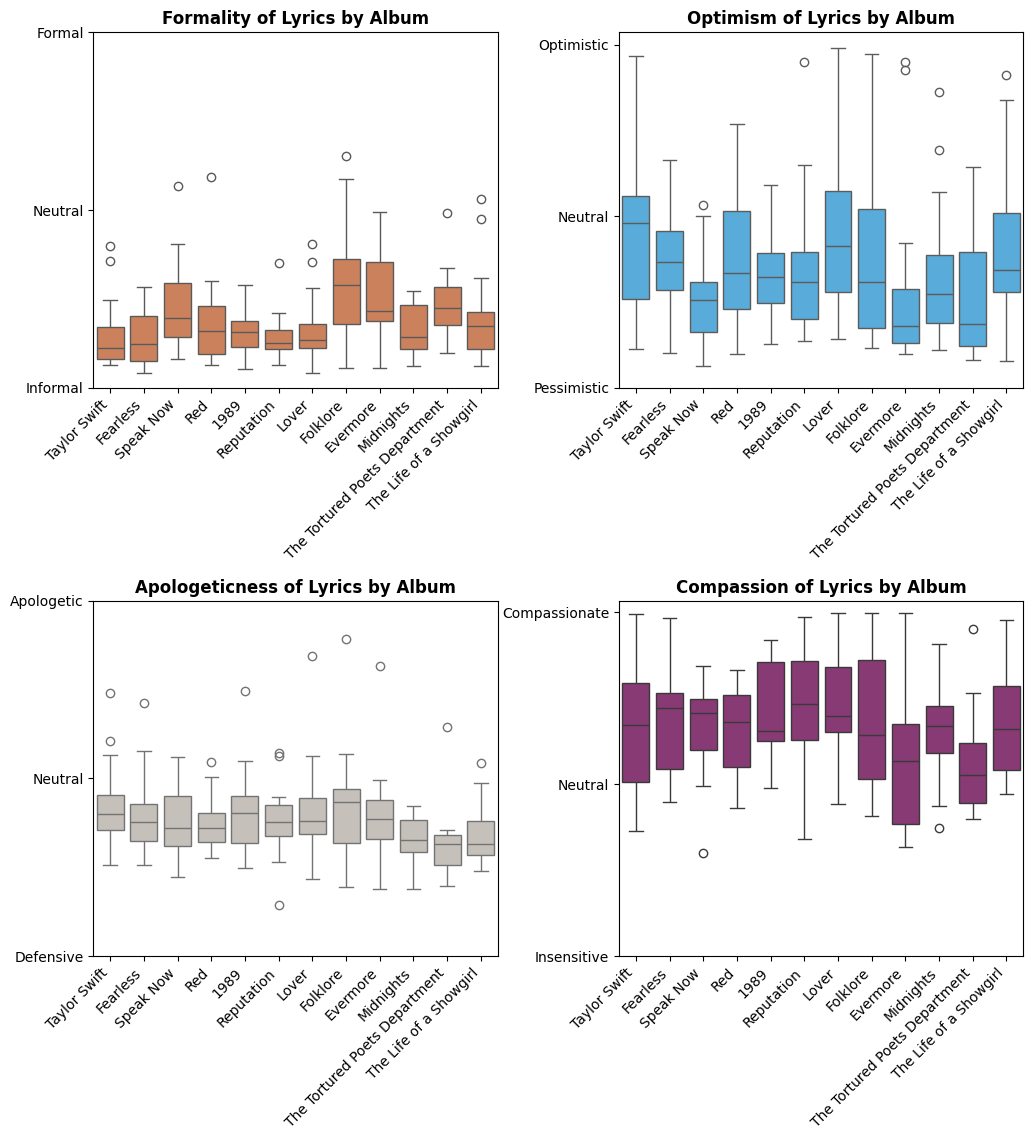

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

sns.boxplot(x="album", y="formality", data=lyrics_df, color="#DF7A4A", order=lyrics_df.groupby(by=["album"]).agg({"release_date": "first"}).sort_values(by=["release_date"]).index, ax=axes[0, 0])
axes[0, 0].set_xticks(range(len(lyrics_df["album"].unique())))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha="right")
axes[0, 0].set_yticks([-1, 0, 1])
axes[0, 0].set_yticklabels(["Informal", "Neutral", "Formal"])
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")
axes[0, 0].set_title("Formality of Lyrics by Album", fontweight="bold")

sns.boxplot(x="album", y="optimism", data=lyrics_df, color="#44B1EE", order=lyrics_df.groupby(by=["album"]).agg({"release_date": "first"}).sort_values(by=["release_date"]).index, ax=axes[0, 1])
axes[0, 1].set_xticks(range(len(lyrics_df["album"].unique())))
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha="right")
axes[0, 1].set_yticks([-1, 0, 1])
axes[0, 1].set_yticklabels(["Pessimistic", "Neutral", "Optimistic"])
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[0, 1].set_title("Optimism of Lyrics by Album", fontweight="bold")

sns.boxplot(x="album", y="apologeticness", data=lyrics_df, color="#C7C2B8", order=lyrics_df.groupby(by=["album"]).agg({"release_date": "first"}).sort_values(by=["release_date"]).index, ax=axes[1, 0])
axes[1, 0].set_xticks(range(len(lyrics_df["album"].unique())))
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha="right")
axes[1, 0].set_yticks([-1, 0, 1])
axes[1, 0].set_yticklabels(["Defensive", "Neutral", "Apologetic"])
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("")
axes[1, 0].set_title("Apologeticness of Lyrics by Album", fontweight="bold")

sns.boxplot(x="album", y="compassion", data=lyrics_df, color="#942D7A", order=lyrics_df.groupby(by=["album"]).agg({"release_date": "first"}).sort_values(by=["release_date"]).index, ax=axes[1, 1])
axes[1, 1].set_xticks(range(len(lyrics_df["album"].unique())))
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha="right")
axes[1, 1].set_yticks([-1, 0, 1])
axes[1, 1].set_yticklabels(["Insensitive", "Neutral", "Compassionate"])
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("")
axes[1, 1].set_title("Compassion of Lyrics by Album", fontweight="bold")

plt.show()

PCA Components:
   Formality  Optimism  Apologeticness  Compassion
0  -0.374917  0.794774        0.100393    0.466576
1   0.576940  0.465622        0.507732   -0.438799
2   0.388653 -0.305298        0.470248    0.731169
3  -0.612802 -0.241502        0.714840   -0.234849

PCA Variance Ratio
[0.71057856 0.14527191 0.10562176 0.03852778]


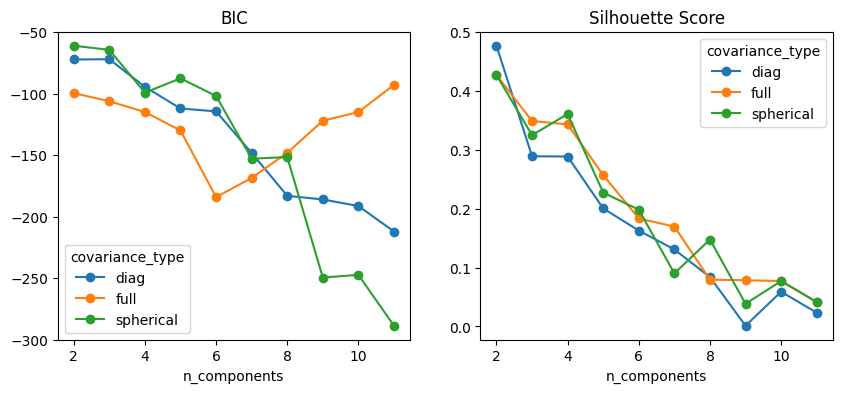

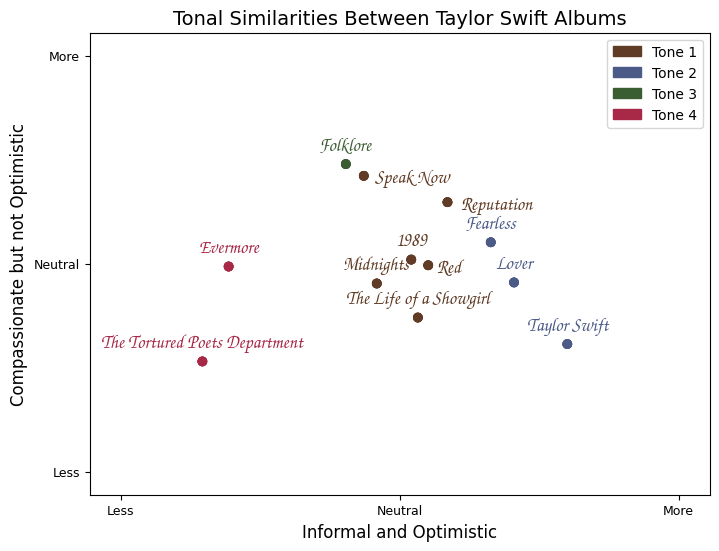

In [79]:
album_df = lyrics_df.groupby(by=["album"]).agg({"release_date": "first",
                                                "formality": "median",
                                                "optimism": "median",
                                                "apologeticness": "median",
                                                "compassion": "median",
                                               })

pca = PCA(n_components=4)
album_df[["PC1", "PC2"]] = pca.fit_transform(album_df[["formality", "optimism", "apologeticness", "compassion"]])[:, [0, 2]]
print("PCA Components:")
print(pd.DataFrame(pca.components_, columns=["Formality", "Optimism", "Apologeticness", "Compassion"]))
print("\nPCA Variance Ratio")
print(pca.explained_variance_ratio_)

results = []
for n_components in range(2, len(album_df)):
    for covariance_type in ("spherical", "diag", "full"):
        model = GaussianMixture(n_components=n_components, covariance_type=covariance_type).fit(album_df[["formality", "optimism", "apologeticness", "compassion"]])
        results += [(n_components, covariance_type, model.bic(album_df[["formality", "optimism", "apologeticness", "compassion"]]), silhouette_score(album_df[["formality", "optimism", "apologeticness", "compassion"]], model.predict(album_df[["formality", "optimism", "apologeticness", "compassion"]])))]

gmm_df = pd.DataFrame(results, columns=["n_components", "covariance_type", "bic", "silhouette_score"])
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
gmm_df.pivot_table(index="n_components", columns="covariance_type", values="bic").plot.line(ax=axes[0], marker="o", title="BIC")
gmm_df.pivot_table(index="n_components", columns="covariance_type", values="silhouette_score").plot.line(ax=axes[1], marker="o", title="Silhouette Score")
plt.show()

album_df["cluster"] = GaussianMixture(n_components=4, covariance_type="full").fit_predict(album_df[["formality", "optimism", "apologeticness", "compassion"]])
album_df["color"] = [{0: "#603B25", 1: "#4C5A87", 2: "#3A5E32", 3: "#A72847", 4: "#5D5954"}[cluster] for cluster in album_df["cluster"]]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Tonal Similarities Between Taylor Swift Albums", fontsize=14)
ax.set_xlim((-0.6, 0.6))
ax.set_ylim((-0.3, 0.3))
ax.set_xlabel("Informal and Optimistic", fontsize=12)
ax.set_ylabel("Compassionate but not Optimistic", fontsize=12)
ax.set_xticks([0] + [0.9 * x for x in ax.get_xlim()])
ax.set_yticks([0] + [0.9 * y for y in ax.get_ylim()])
ax.set_xticklabels(["Neutral", "Less", "More"], fontsize=9)
ax.set_yticklabels(["Neutral", "Less", "More"], fontsize=9)

for cluster in album_df["cluster"].unique():
    subset = album_df[album_df["cluster"] == cluster]
    ax.scatter(album_df["PC1"], album_df["PC2"], color=album_df["color"], label=f"Tonal Group {cluster}")

for album_name, row in album_df.iterrows():
    if album_name == "Speak Now":
        xytext = (35, -5)
    elif album_name == "Red":
        xytext = (15, -5)
    elif album_name == "Reputation":
        xytext = (35, -5)
    else:
        xytext = (0, 10)
    ax.annotate(album_name, (row["PC1"], row["PC2"]),
                textcoords="offset points", xytext=xytext,
                ha="center", color=row["color"], 
                fontname="Z003", fontsize=13, fontweight="bold")

ax.legend(handles=[matplotlib.patches.Patch(color="#603B25", label="Tone 1"),
                   matplotlib.patches.Patch(color="#4C5A87", label="Tone 2"),
                   matplotlib.patches.Patch(color="#3A5E32", label="Tone 3"),
                   matplotlib.patches.Patch(color="#A72847", label="Tone 4")])
plt.show()